<a href="https://colab.research.google.com/github/may-/joeynmt/blob/speechjoey/notebooks/SLR32_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SpeechJoey demo: OPEN SLR 32 dataset

**last update:** 2021/10/04  
**author:** May Ohta <ohta@cl.uni-heidelberg.de>

Please make sure you enabled GPU runtime.

In [ ]:
!nvidia-smi

Wed Sep 15 13:47:09 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Install the right PyTorch version. 

In [ ]:
!pip install torch==1.9.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
!pip install pandas datasets vizseq

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████                   | 834.1 MB 1.4 MB/s eta 0:13:56tcmalloc: large alloc 1147494400 bytes == 0x55efda098000 @  0x7f04c649d615 0x55efa10894cc 0x55efa116947a 0x55efa108c2ed 0x55efa117de1d 0x55efa10ffe99 0x55efa10fa9ee 0x55efa108dbda 0x55efa10ffd00 0x55efa10fa9ee 0x55efa108dbda 0x55efa10fc737 0x55efa117ec66 0x55efa10fbdaf 0x55efa117ec66 0x55efa10fbdaf 0x55efa117ec66 0x55efa10fbdaf 0x55efa108e039 0x55efa10d1409 0x55efa108cc52 0x55efa10ffc25 0x55efa10fa9ee 0x55efa108dbda 0x55efa10fc737 0x55efa10fa9ee 0x55efa108dbda 0x55efa10fb915 0x55efa108dafa 0x55efa10fbc0d 0x55efa10fa9ee
     |████████████████▌               | 1055.7 MB 1.6 MB/s eta 0:10:05tcmalloc: large alloc 1434370048 bytes == 0x55f01e6ee000 @  0x7f04c649d615 0x55efa10894cc 0x55efa116947a 0x55efa108c2ed 0x55efa117de1d 0x55efa10ffe99 0x55efa10fa9ee 0x55efa108dbda 0x55efa10ffd00 0x55efa10fa9ee 0x55efa108dbda 0x55efa10fc737 0x55efa117ec66 0x55efa10fbd

Mount your google drive. We save the data there, so that we can resume the process without restarting from NULL, even after the runtime is disconnected.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Fetch SpeechJoey and install it. You might have to restart the runtime after installing SpeechJoey.

In [ ]:
!cd /content/drive/MyDrive/ && git clone https://github.com/may-/joeynmt.git
!cd /content/drive/MyDrive/joeynmt && git checkout speechjoey && pip install -e .

M	joeynmt/prediction.py
M	joeynmt/vocabulary.py
M	scripts/generate_copy_task.py
M	scripts/generate_reverse_task.py
M	scripts/get_iwslt14_bpe.sh
M	scripts/get_iwslt14_sp.sh
M	scripts/get_iwslt15_envi.sh
M	scripts/get_jparaclawl.sh
M	scripts/plot_validations.py
M	setup.py
Already on 'speechjoey'
Your branch is up to date with 'origin/speechjoey'.
Obtaining file:///content/drive/MyDrive/joeynmt
     |████████████████████████████████| 15.7 MB 196 kB/s 
     |████████████████████████████████| 1.2 MB 51.6 MB/s 
     |████████████████████████████████| 392 kB 47.5 MB/s 
     |████████████████████████████████| 242 kB 57.4 MB/s 
     |████████████████████████████████| 106 kB 47.3 MB/s 
     |████████████████████████████████| 743 kB 32.1 MB/s 
     |████████████████████████████████| 55 kB 4.4 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.7.4.3
    Uninstalling typing-extensions-3.7.4.3:
      Successfully uninstalled typing-extensions-3.7.4.3

Check if the joeynmt path at '/content/drive/MyDrive/joeynmt/joeynmt' can be found. If you encounter an error, please try to restart the runtime.

In [ ]:
import joeynmt
joeynmt.__path__

['/content/drive/MyDrive/joeynmt/joeynmt']

## Data pre-processing

We will reuse some functions defined in `/content/drive/MyDrive/joeynmt/scripts/audiodata_utils.py`

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/joeynmt/scripts')

We use OPEN SLR 32 dataset in this demo.

- https://www.openslr.org/32/
- https://huggingface.co/datasets/openslr

In [ ]:
from datasets import load_dataset

dataset = load_dataset("openslr", "SLR32")
dataset

WARNING - 10/04/21 22:14:37 - 0:00:23 - Reusing dataset open_slr (/home/students/ohta/.cache/huggingface/datasets/open_slr/SLR32/0.0.0/6bfe61a587ab51a421bcdfb71e6d51a3e050e529766de63dfc5fcf6c1bd8dff8)


  0%|          | 0/1 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['path', 'sentence'],
        num_rows: 9821
    })
})

Let's inspect one example.

In [ ]:
from pathlib import Path

first_instance = dataset['train'][0]
print('file:', Path(first_instance['path']).name)
print('lang:', Path(first_instance['path']).parents[3].name)
print('sent:', first_instance['sentence'])

file: afr_8963_6542844630.wav
lang: za
sent: Mbali het koppies meel nodig om 'n koek te bak.


In [ ]:
from IPython.display import display, Audio
import torchaudio

wav, sample_rate = torchaudio.load(first_instance['path'])
display(Audio(wav[0], rate=sample_rate))

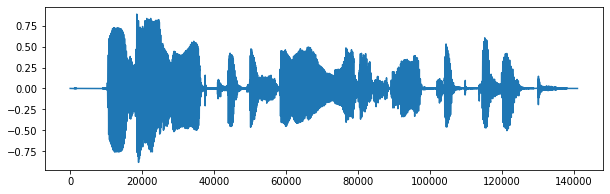

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.plot(wav[0,:].t().numpy())
plt.show()

Now we extract mel filterbank features with the frequency of 80. We will save the extracted features in `/content/drive/MyDrive/data/SLR32/fbank80` in numpy array format.

In [ ]:
!mkdir /content/drive/MyDrive/data/SLR32
!mkdir /content/drive/MyDrive/data/SLR32/fbank80

In [ ]:
from tqdm.notebook import tqdm
from joeynmt.helpers_for_audio import extract_fbank_features

data_root = Path('/content/drive/MyDrive/data')
feature_root = data_root / 'fbank80'

print(f"Extracting log mel filter bank features on SLR32 set...")
for utt_id, instance in enumerate(tqdm(dataset['train'])):
    wav, sample_rate = torchaudio.load(instance['path'])
    try:
        extract_fbank_features(waveform=wav,
                               sample_rate=sample_rate,
                               output_path=feature_root / f'{utt_id}.npy',
                               n_mel_bins=80,
                               overwrite=False)
    except Exception as e:
        print(utt_id, e)

Extracting log mel filter bank features on SLR32 set...


  0%|          | 0/9821 [00:00<?, ?it/s]


The spectrogram of the example above looks like this:

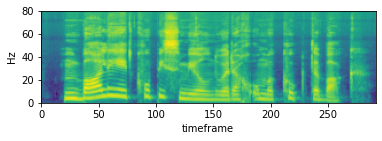

In [ ]:
import numpy as np

def plot_spectrogram(x, figsize=(6,12)):
    plt.figure(figsize=figsize)
    plt.imshow(x.T)
    plt.ylim((0, 80))
    plt.ylabel('Hz')
    plt.xlabel('timeframe')
    plt.show()

npy = np.load((feature_root / '0.npy'))
plot_spectrogram(npy)

Pack features into ZIP

In [ ]:
from scripts.audiodata_utils import create_zip, get_zip_manifest

print("ZIPing features...")
create_zip(feature_root, feature_root.with_suffix(".zip"))

print("Fetching ZIP manifest...")
zip_manifest = get_zip_manifest(feature_root.with_suffix(".zip"))

Fetching ZIP manifest...


100%|██████████| 9821/9821 [00:05<00:00, 1725.72it/s]


Generate TSV manifest

In [ ]:
import pandas as pd

print("Generating manifest...")
all_data = []

for utt_id, instance in enumerate(tqdm(dataset['train'])):
    n_frames = np.load(feature_root / f'{utt_id}.npy').shape[0]
    try:
        record = {
            "id": utt_id,
            "src": zip_manifest[str(utt_id)],
            "n_frames": n_frames,
            "trg": instance['sentence']
        }
        all_data.append(record)
    except Exception as e:
        print(utt_id, e)

all_df = pd.DataFrame.from_records(all_data)
all_df 

Generating manifest...


  0%|          | 0/9821 [00:00<?, ?it/s]

id                            src  n_frames  \
0        0     fbank80.zip:40592925:93568       292   
1        1  fbank80.zip:1428060687:139328       435   
2        2   fbank80.zip:485845154:209088       653   
3        3    fbank80.zip:237529093:77248       241   
4        4  fbank80.zip:1501390417:138368       432   
...    ...                            ...       ...   
9816  9816     fbank80.zip:50634272:71488       223   
9817  9817  fbank80.zip:1427705633:102848       321   
9818  9818  fbank80.zip:1322145165:202688       633   
9819  9819   fbank80.zip:311168245:348928      1090   
9820  9820   fbank80.zip:897069436:176448       551   

                                                    trg  
0       Mbali het koppies meel nodig om 'n koek te bak.  
1     Haar proeftydperk in die oorlog maak sy deur o...  
2     Hedendaagse Turkye is 'n demokratiese, sekulêr...  
3         Die paaltjiewagter staan agter die paaltjies.  
4     Op die bepaalde datum was D. S. Diedericks ree...  
...                                                 ...  
9816                            Yeyiphi oya kuyikhetha?  
9817               Yiya eMzantsi-Ntshona kwi-Main road.  
9818  Endaweni kaMnumzana Ngonyama, kukho uNkosikazi...  
9819  I-AZAPO yakhululwa ekuvalweni umlomo ngonyaka ...  
9820  Ikepusi yam Yaxhaseka esebeni lomthi omdala we...  

[9821 rows x 4 columns]

Next, we split the data into train and test set and save the splits in tsv.


In [ ]:
from joeynmt.helpers import write_list_to_file
from scripts.audiodata_utils import save_tsv
import numpy as np

np.random.seed(123)
probs = np.random.rand(len(all_df))
mask = {}
mask['train'] = probs < 0.995
mask['dev'] = (0.995 <= probs) & (probs < 0.998)
mask['test'] = 0.998 <= probs

for split in ['train', 'dev', 'test']:
    split_df = all_df[mask[split]]
    # save tsv
    save_tsv(split_df, data_root/f"{split}.tsv")
    # save plain txt
    write_list_to_file(data_root/f"{split}.txt", split_df['trg'].to_list())
    print(split, len(split_df))
    

Then, train a sentencepiece tokenizer model on the train split.

In [ ]:
from scripts.audiodata_utils import build_sp_model

kwargs = {'model_type': 'bpe',
          'vocab_size': 1000,
          'character_coverage': 1.0,
          'num_workers': 4}
spm = build_sp_model(data_root/"train.txt", data_root/"spm_bpe1000", **kwargs)

Quickly check the trained tokenization. Note that you don't have to apply the tokenization to the trg texts in tsv.

In [ ]:
print(first_instance['sentence'])
print(spm.encode(first_instance['sentence'], out_type=str))

Mbali het koppies meel nodig om 'n koek te bak.
['▁M', 'ba', 'li', '▁het', '▁k', 'op', 'pies', '▁me', 'el', '▁no', 'dig', '▁om', "▁'", 'n', '▁ko', 'ek', '▁te', '▁ba', 'k', '.']


And the vocabulary file with counts:

In [ ]:
!head -10 /content/drive/MyDrive/data/SLR32/spm_bpe1000.tsv

input file for joey looks like this:

In [ ]:
!head -10 /content/drive/MyDrive/data/SLR32/train.tsv

## Model Training

Create a dir to store the checkpoints:

In [ ]:
!mkdir /content/models 

SpeechJoey reads model and training hyperparameters from a configuration file.



In [ ]:
model_root = Path('/content/models')
config = """
name: "OPENSLR32-asr"
joeynmt_version: 1.4

data:
    task: "s2t"
    root_path: "{data_root}"
    train: "train"
    dev: "dev"
    test: "test"
    src:
        num_freq: 80
        #max_length: 3000
    trg:
        level: "bpe"
        lowercase: False
        tokenizer: "sentencepiece"
        #max_length: 80
        #voc_min_freq: 1
        #voc_limit: 1000
        voc_file: "{data_root}/spm_bpe1000.tsv" # vocab file: one token per line. Alternatively, you can set the vocab file with frequency counts (tab-separated)
        spm:
            model_file: "{data_root}/spm_bpe1000.model"
            enable_sampling: False # whether to enable BPE dropout
    specaugment:
        freq_mask_n: 1
        freq_mask_f: 8
        time_mask_n: 1
        time_mask_t: 20
        time_mask_p: 1.0
    cmvn:
        norm_means: True
        norm_vars: True
        before: True

testing:
    beam_size: 10
    alpha: 1.0
    sacrebleu:
        remove_whitespace: True
        tokenize: "intl"

training:
    #load_model: "{model_root}/SLR32/best.ckpt"
    random_seed: 123
    optimizer: "adam"
    adam_betas: [0.9, 0.99]
    scheduling: "warmupinversesquareroot"
    learning_rate: 2.0e-5
    learning_rate_min: 1.0e-9
    learning_rate_warmup: 800
    clip_grad_norm: 10.0
    weight_decay: 0.0
    label_smoothing: 0.1
    batch_multiplier: 1
    normalization: "batch"
    batch_size: 32
    batch_type: "sentence"
    eval_batch_size: 32
    eval_batch_type: "sentence"
    early_stopping_metric: "eval_metric"
    epochs: 5
    validation_freq: 1000
    logging_freq: 100
    eval_metrics: "wer"
    model_dir: "{model_root}/SLR32"
    overwrite: False
    shuffle: True
    use_cuda: True
    fp16: False
    max_output_length: 100
    print_valid_sents: [0, 1, 2]
    keep_best_ckpts: 3
    loss: "crossentropy-ctc"
    ctc_weight: 0.3

model:
    initializer: "xavier"
    init_gain: 1.0
    embed_initializer: "xavier"
    embed_init_gain: 1.0
    bias_initializer: "zeros"
    tied_embeddings: False
    tied_softmax: False
    encoder:
        type: "transformer"
        num_layers: 12
        num_heads: 8
        embeddings:
            embedding_dim: 80
            #embedding_dim: 512
            #scale: True
            #dropout: 0.
            #freeze: False
        # typically ff_size = 8 x hidden_size
        hidden_size: 512
        ff_size: 2048
        dropout: 0.15
        freeze: False
        subsample: True
        conv_kernel_sizes: 5,5
        conv_channels: 512
        in_channels: 80
    decoder:
        type: "transformer"
        num_layers: 6
        num_heads: 8
        embeddings:
            embedding_dim: 512
            scale: True
            dropout: 0.
            freeze: False
        # ff_size = 8 x hidden_size
        hidden_size: 512
        ff_size: 2048
        dropout: 0.15
        freeze: False
""".format(data_root=data_root.as_posix(), model_root=model_root.as_posix())
with open('/content/drive/MyDrive/joeynmt/configs/SLR32_asr.yaml','w') as f:
    f.write(config)

Load the TensorBoard notebook extension. It will be empty at first.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir /content/models/SLR32/tensorboard

Reusing TensorBoard on port 6006 (pid 15764), started 0:01:50 ago. (Use '!kill 15764' to kill it.)

Then, start the ASR training on Open SLR 32 dataset.

In [ ]:
!python -m joeynmt train /content/drive/MyDrive/joeynmt/configs/SLR32_asr.yaml

[.zshenv] logged on gpu05
HOME=/home/students/ohta
PATH=/usr/local/cuda-11.1/bin:/home/students/ohta/joeynmt/jnmt/bin:/usr/local/cuda-11.1/bin:/home/students/ohta/miniconda3/bin:/home/students/ohta/miniconda3/condabin:/home/students/ohta/miniconda3/bin:/home/students/ohta/tools/bin:/opt/slurm/bin:/usr/local/bin:/usr/bin:/bin:/usr/local/games:/usr/games
LD_LIBRARY_PATH=/usr/local/cuda-11.1/lib64:/extras/CUPTI/lib64:/usr/local/cuda-11.1/lib64:/extras/CUPTI/lib64:/home/students/ohta/miniconda3/lib:/home/students/ohta/tools/lib
CUDA_HOME=/usr/local/cuda-11.1
CUDA_VISIBLE_DEVICES=0,2
$(which python)=/home/students/ohta/joeynmt/jnmt/bin/python
PWD=/home/students/ohta/joeynmt
2021-10-04 21:40:52,415 - INFO - root - Hello! This is Joey-NMT (version 1.4).
2021-10-04 21:40:52,416 - INFO - joeynmt.helpers - cfg.name                           : SLR32-asr
2021-10-04 21:40:52,416 - INFO - joeynmt.helpers - cfg.joeynmt_version                : 1.4
2021-10-04 21:40:52,416 - INFO - joeynmt.helpers - cf

Let's check the performance on test split.

Note: you might need downgrade sacrebleu to 1.5.1 to make vizseq work.  
`!pip install --upgrade sacrebleu==1.5.1`

In [ ]:
import vizseq
src = [x['path'] for i, x in enumerate(dataset['train']) if i in all_df[mask['test']].index]
ref = (data_root / 'test.txt').as_posix()
hyp = list((model_root / 'SLR32').glob('00*.hyps.test'))[0].as_posix()
vizseq.view_examples({'speech': src}, references=ref, hypothesis=hyp, metrics=['wer'], page_sz=10)